# Notebook TITANIC AutoML avec Azure ML


Notebook Python Azure ML pour la modélisation automatique (AUTOML) de la survie des passagers du Titanic.
<br><br>
https://www.kaggle.com/c/titanic
<br><br>
Données : 
https://www.kaggle.com/c/titanic/data

<img src="https://kwmp.ca/wp-content/uploads/2018/04/titanic-the-musical-1024x538.jpg">

 ## Description des variables :
 - PassengerId: and id given to each traveler on the boat
 - Pclass: the passenger class. It has three possible values: 1,2,3 (first, second and third class)
 - The Name of the passeger
 - The Sex
 - The Age
 - SibSp: number of siblings and spouses traveling with the passenger
 - Parch: number of parents and children traveling with the passenger
 - The ticket number
 - The ticket Fare
 - The cabin number
 - The embarkation. This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q

> https://www.kaggle.com/c/titanic

### 0. Paramétrage

In [70]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platforme']=platform.system()
        info['Platforme-release']=platform.release()
        info['Platforme-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processeur']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platforme': 'Linux',
 'Platforme-release': '4.15.0-1092-azure',
 'Platforme-version': '#102~16.04.1-Ubuntu SMP Tue Jul 14 20:28:23 UTC 2020',
 'Architecture': 'x86_64',
 'Hostname': 'instancenotebooksjup',
 'IP-address': '127.0.0.1',
 'MAC-address': '00:0d:3a:23:7a:f6',
 'Processeur': 'x86_64',
 'RAM': '14 Go'}

In [71]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [72]:
import datetime
now = datetime.datetime.now()
print(now)

2020-08-27 13:07:52.021227


In [73]:
#!pip install --upgrade azureml-sdk
#!pip install --upgrade azureml-sdk[automl,notebooks,explain,contrib,services,tensorboard]

In [74]:
#!pip install flask==1.0.3

In [75]:
import azureml.core
print("Version Azure ML :", azureml.core.VERSION)

Version Azure ML : 1.12.0


In [76]:
import os

subscription_id = os.environ.get("SUBSCRIPTION_ID", "70b8f39e-8863-49f7-b6ba-34a80799550c")
resource_group = os.environ.get("RESOURCE_GROUP", "workshop-rg")
workspace_name = os.environ.get("WORKSPACE_NAME", "workshop")

In [77]:
from azureml.core import Workspace

try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("Le workspace Azure ML service a été trouvé : OK")
except:
   print("Le workspace Azure ML service n'a pas été trouvé")

Le workspace Azure ML service a été trouvé : OK


In [78]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

import logging
import os
import random

## 1. Chargement des données

In [79]:
import azureml.dataprep as dprep

In [80]:
pd.set_option('display.max_columns', None)

titanic_path = "https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"

print("Retrieving data:")
print(titanic_path)

titanic_df = dprep.read_csv(path=titanic_path, header=dprep.PromoteHeadersMode.GROUPED)

display(titanic_df.head(5))

Retrieving data:
https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [81]:
all_columns = dprep.ColumnSelector(term=".*", use_regex=True)

drop_if_all_null = [all_columns, dprep.ColumnRelationship(dprep.ColumnRelationship.ALL)]

useful_columns = [
    "PassengerId", "Survived", "Pclass", "Sex", "Age", "SibSp",
    "Fare", "Embarked"
]

tmp_df = (titanic_df
    .replace_na(columns=all_columns)
    .drop_nulls(*drop_if_all_null)
    .rename_columns(column_pairs={
        "PassengerId": "PassengerId",
        "Survived": "Survived",
        "Pclass": "Pclass",
        "Sex": "Sex",
        "Age": "Age",
        "SibSp": "SibSp",
        "Fare": "Fare",
        "Embarked": "Embarked",
     })
    .keep_columns(columns=useful_columns))
tmp_df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,1,0,3,male,22,1,7.25,S
1,2,1,1,female,38,1,71.2833,C
2,3,1,3,female,26,0,7.925,S
3,4,1,1,female,35,1,53.1,S
4,5,0,3,male,35,0,8.05,S


In [82]:
decimal_type = dprep.TypeConverter(data_type=dprep.FieldType.DECIMAL)
profile = tmp_df.set_column_types(type_conversions={
    "Age": decimal_type,
    "Fare": decimal_type
}).get_profile()

In [83]:
profile

,Type,Min,Max,Count,Missing Count,Not Missing Count,Percent Missing,Error Count,Empty Count,Unique Values,0.1% Quantile (est.),1% Quantile (est.),5% Quantile (est.),25% Quantile (est.),50% Quantile (est.),75% Quantile (est.),95% Quantile (est.),99% Quantile (est.),99.9% Quantile (est.),Mean,Standard Deviation,Variance,Skewness,Kurtosis,WhiskerTop,WhiskerBottom
PassengerId,FieldType.STRING,1,99,891.00,0.00,891.00,0.00,0.00,0.00,891,,,,,,,,,,,,,,,,
Survived,FieldType.STRING,0,1,891.00,0.00,891.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
Pclass,FieldType.STRING,1,3,891.00,0.00,891.00,0.00,0.00,0.00,3,,,,,,,,,,,,,,,,
Sex,FieldType.STRING,female,male,891.00,0.00,891.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
Age,FieldType.DECIMAL,0.42,80.00,891.00,177.00,714.00,0.20,0.00,0.00,89,0.47,13.51,12.67,20.28,28.00,38.20,56.31,67.44,78.72,29.70,14.53,211.02,0.39,0.16,65.00,0.42
SibSp,FieldType.STRING,0,8,891.00,0.00,891.00,0.00,0.00,0.00,7,,,,,,,,,,,,,,,,
Fare,FieldType.DECIMAL,0.00,512.33,891.00,0.00,891.00,0.00,0.00,0.00,248,0.00,7.54,7.52,7.91,14.46,31.07,112.45,255.39,512.33,32.20,49.69,2469.44,4.77,33.12,63.34,0.00
Embarked,FieldType.STRING,C,S,891.00,2.00,889.00,0.00,0.00,0.00,4,,,,,,,,,,,,,,,,


In [84]:
url="https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"
df=pd.read_csv(url, index_col=None, na_values=['NA'])

In [85]:
df.isna().sum()

PassengerId    0  
Survived       0  
Pclass         0  
Name           0  
Sex            0  
Age            177
SibSp          0  
Parch          0  
Ticket         0  
Fare           0  
Cabin          687
Embarked       2  
dtype: int64

In [86]:
# Suppression valeurs manquantes
df = df.dropna()

In [87]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [88]:
# Nombre de col et de lignes
df.shape

(183, 12)

In [89]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [90]:
df.dtypes

PassengerId    int64  
Survived       int64  
Pclass         int64  
Name           object 
Sex            object 
Age            float64
SibSp          int64  
Parch          int64  
Ticket         object 
Fare           float64
Cabin          object 
Embarked       object 
dtype: object

In [91]:
# Suppression de colonnes
df = df.drop(['Cabin','Parch'],axis=1)

In [92]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,PC 17599,71.28,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,113803,53.10,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,17463,51.86,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,PP 9549,16.70,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,113783,26.55,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.00,0,248698,13.00,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.00,0,113788,35.50,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,19950,263.00,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.00,1,PC 17572,76.73,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.00,0,113509,61.98,C


## 2. Analyses exploratoires

In [93]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
count,183.00,183.00,183.00,183.00,183.00,183.00
mean,455.37,0.67,1.19,35.67,0.46,78.68
std,247.05,0.47,0.52,15.64,0.64,76.35
min,2.00,0.00,1.00,0.92,0.00,0.00
25%,263.50,0.00,1.00,24.00,0.00,29.70
50%,457.00,1.00,1.00,36.00,0.00,57.00
75%,676.00,1.00,1.00,47.50,1.00,90.00
max,890.00,1.00,3.00,80.00,3.00,512.33


In [94]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
PassengerId,1.00,0.15,-0.09,0.03,-0.08,0.03
Survived,0.15,1.00,-0.03,-0.25,0.11,0.13
Pclass,-0.09,-0.03,1.00,-0.31,-0.10,-0.32
Age,0.03,-0.25,-0.31,1.00,-0.16,-0.09
SibSp,-0.08,0.11,-0.10,-0.16,1.00,0.29
Fare,0.03,0.13,-0.32,-0.09,0.29,1.00


## 3. Modélisation AutoML avec Azure ML service

<img src="https://blog.cellenza.com/wp-content/uploads/2018/11/automl.png">

In [95]:
col_target=['Survived']
col_train=['Age','Pclass','Sex','Fare','SibSp','Embarked']
X=df[col_train]
y=df[col_target]

In [96]:
X.describe()

,Age,Pclass,Fare,SibSp
count,183.00,183.00,183.00,183.00
mean,35.67,1.19,78.68,0.46
std,15.64,0.52,76.35,0.64
min,0.92,1.00,0.00,0.00
25%,24.00,1.00,29.70,0.00
50%,36.00,1.00,57.00,0.00
75%,47.50,1.00,90.00,1.00
max,80.00,3.00,512.33,3.00


In [97]:
dic = {'male':0,'female':1}
X['Sex']=X['Sex'].apply(lambda x:dic[x])

### 3.1 Partitionnement des données

In [98]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=10)

In [99]:
print(X.shape)

(183, 6)


In [100]:
print(X_train.shape)

(128, 6)


In [101]:
print(X_test.shape)

(55, 6)


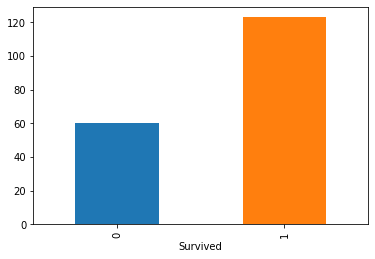

In [102]:
df.groupby('Survived').size().plot(kind='bar')

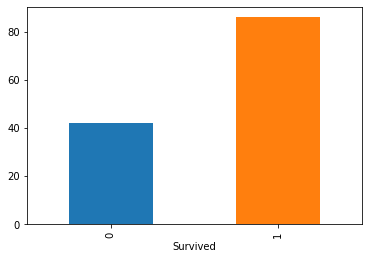

In [103]:
# Sur le Training
y_train.groupby('Survived').size().plot(kind='bar')

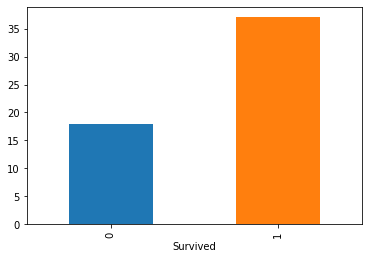

In [104]:
# Sur le test
y_test.groupby('Survived').size().plot(kind='bar')

### 3.2 Connexion workspace Azure ML service

In [105]:
ws = Workspace.from_config()

experiment_name = 'AutoMLTitanicSDK'

project_folder = './sample_projects/automltitanicsdk'

In [106]:
experiment = Experiment(ws, experiment_name)

output = {}
output['Version Azure ML service'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
Version Azure ML service,1.12.0
Workspace Name,workshop
Resource Group,workshop-rg
Location,westeurope
Project Directory,./sample_projects/automltitanicsdk
Experiment Name,AutoMLTitanicSDK


### 3.3 AutoML avec Azure ML service

### Les principes de l'autoML

 https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

### Aide en ligne AutoML avec Azure ML service

https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### Paramétrage AutoML

In [107]:
automl_settings = {
    "iteration_timeout_minutes" : 2,
    "experiment_timeout_minutes" : 15,
    "iterations" : 10,                  
    "primary_metric" : 'AUC_weighted',
    "enable_early_stopping" : "True",
    "verbosity" : logging.INFO,
    "enable_voting_ensemble":"False",     # Pas de voting
    "enable_stack_ensemble":"False"       # Pas d'ensemble
    }

In [108]:
from azureml.train.automl import AutoMLConfig

automated_ml_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             model_explainability=True, # Explanibility du meilleur modèle
                             X = X_train.values,
                             y = y_train.values.flatten(),
                             X_valid = X_test.values,
                             y_valid = y_test.values.flatten(),
                             **automl_settings)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


> Liste des modèles disponibles : https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### Exécution de la recherche du meilleur modèle via Azure ML AutoML

In [109]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(automated_ml_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were 

### Visualisation des itérations depuis le portail Azure :

In [110]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLTitanicSDK,AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### Widget AutoML

In [111]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 3.4 Liste des résultats autoML

In [112]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.85,0.87,0.84,0.88,0.86,0.84,0.86,0.87,0.89,0.88
AUC_micro,0.86,0.88,0.86,0.88,0.88,0.86,0.89,0.86,0.90,0.89
AUC_weighted,0.85,0.87,0.84,0.88,0.86,0.84,0.86,0.87,0.89,0.88
accuracy,0.73,0.76,0.75,0.76,0.76,0.71,0.75,0.78,0.76,0.75
average_precision_score_macro,0.82,0.85,0.83,0.86,0.81,0.81,0.83,0.84,0.87,0.87
average_precision_score_micro,0.88,0.89,0.88,0.89,0.89,0.87,0.90,0.87,0.90,0.90
average_precision_score_weighted,0.86,0.88,0.86,0.89,0.86,0.85,0.87,0.88,0.90,0.90
balanced_accuracy,0.64,0.70,0.64,0.81,0.78,0.70,0.74,0.68,0.68,0.71
f1_score_macro,0.65,0.71,0.65,0.76,0.75,0.69,0.73,0.70,0.70,0.71
f1_score_micro,0.73,0.76,0.75,0.76,0.76,0.71,0.75,0.78,0.76,0.75


### 3.5 Choix du meilleur modèle selon l'AUC

In [113]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon l'AUC :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon l'AUC :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [114]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])>

In [115]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('MaxAbsScaler', MaxAbsScaler(copy=True)),
 ('RandomForestClassifier',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.01, min_samples_split=0.01,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

### 3.6 Changement métrique de qualité

Autres métriques disponibles :
accuracy, AUC_weighted, average_precision_score_weighted, norm_macro_recall, precision_score_weighted

In [116]:
lookup_metric = "f1_score_weighted"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon le score F1 :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon le score F1 :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...'log', max_iter=1000, n_jobs=1,
           penalty='none', power_t=0, random_state=None, tol=0.01))])


In [117]:
lookup_metric = "accuracy"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon accuracy :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon accuracy :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c_7,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...    n_jobs=1, penalty='none', power_t=0.3333333333333333,
           random_state=None, tol=0.001))])


### 3.7 Choix d'une itération particulière

In [118]:
moniteration = 2

In [119]:
my_run, my_model = local_run.get_output(iteration = moniteration)

print("Pipeline "+ str(moniteration) +"ème itération :")
print("")
print(my_run)
print("")
print(my_model)

Pipeline 2ème itération :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c_2,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


### 4. On applique le modèle sur la base de Test

### 4.1 On utilise le meilleur modèle selon l'AUC

In [120]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon la métrique initiale :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon la métrique initiale :

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [121]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, ' = ', metric)

Run(Experiment: AutoMLTitanicSDK,
Id: AutoML_1a16a5a7-f434-4d8f-b0a0-c37d5f9a934c_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

weighted_accuracy  =  0.8281157708210278
f1_score_micro  =  0.7636363636363637
average_precision_score_weighted  =  0.8978862880884544
recall_score_macro  =  0.6816816816816818
matthews_correlation  =  0.4262413420606707
AUC_micro  =  0.8960330578512397
AUC_weighted  =  0.8866366366366367
precision_score_weighted  =  0.7578512396694215
precision_score_micro  =  0.7636363636363637
average_precision_score_macro  =  0.8740169159000355
recall_score_w

In [122]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Titanic-model',
                        tags={'Training context':'Azure Auto ML SDK'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})


Model(workspace=Workspace.create(name='workshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshop-rg'), name=Titanic-model, id=Titanic-model:2, version=2, tags={'Training context': 'Azure Auto ML SDK'}, properties={'AUC': '0.8866366366366367', 'Accuracy': '0.7636363636363637'})

In [123]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, 'version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Titanic-model version = 2
	 Training context : Azure Auto ML SDK
	 AUC : 0.8866366366366367
	 Accuracy : 0.7636363636363637


amlstudio-titanic-real-time-in version = 1
	 CreatedByAMLStudio : true


Titanic-model version = 1
	 Training context : Azure Auto ML SDK
	 AUC : 0.9099099099099098
	 Accuracy : 0.8181818181818182




### 4.2 On applique le modèle

In [124]:
# Calcul de la décision
y_test_pred = fitted_model.predict(X_test.values)

In [125]:
Decision=pd.DataFrame(y_test_pred)

In [126]:
# Obtention des scores
proba=fitted_model.predict_proba(X_test.values)

In [127]:
Decision.columns = ['Decision']
Decision.head()

,Decision
0,1
1,1
2,0
3,1
4,1


In [128]:
Proba=pd.DataFrame(proba)

In [129]:
Proba.columns = ['Proba_0', 'Proba_1']

In [130]:
Proba.head()

,Proba_0,Proba_1
0,0.07,0.93
1,0.03,0.97
2,0.95,0.05
3,0.11,0.89
4,0.01,0.99


In [131]:
Scoring = pd.concat([Decision, Proba], axis=1)

### 4.3 Résultats du scoring

In [132]:
Scoring.head()

,Decision,Proba_0,Proba_1
0,1,0.07,0.93
1,1,0.03,0.97
2,0,0.95,0.05
3,1,0.11,0.89
4,1,0.01,0.99


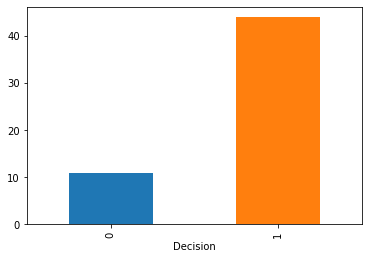

In [133]:
Scoring.groupby('Decision').size().plot(kind='bar')

In [134]:
Scoring.describe()

,Decision,Proba_0,Proba_1
count,55.00,55.00,55.00
mean,0.80,0.29,0.71
std,0.40,0.26,0.26
min,0.00,0.01,0.05
25%,1.00,0.09,0.54
50%,1.00,0.20,0.80
75%,1.00,0.46,0.91
max,1.00,0.95,0.99


### 4.4 Exportation des scores dans un fichier CSV

In [135]:
import time
datedujour = time.strftime("%Y-%m-%d-%H%M%S")

In [136]:
# Export
Scoring.to_csv(r'Export_Titanic'+datedujour+'.csv')

In [137]:
# Visualisation des fichiers
%ls Export*.csv -ls

3 -rwxrwxrwx 1 root root 2396 Aug 27 12:52 Export_Titanic2020-08-27-125256.csv*
3 -rwxrwxrwx 1 root root 2091 Aug 27 13:15 Export_Titanic2020-08-27-131530.csv*


> Fin